In [ ]:
%matplotlib notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os 
from tqdm import tqdm

import multiprocessing as mp

import time 
from natsort import natsorted
import moviepy.video.io.ImageSequenceClip

import copy 

import pickle as pkl

In [ ]:
sys.setrecursionlimit(10000) 

In [4]:
from simulation import leapfrog
from visualizer import renderParticles, drawTree, plotter

In [5]:
plt.ioff()

<IPython.core.display.Javascript object>


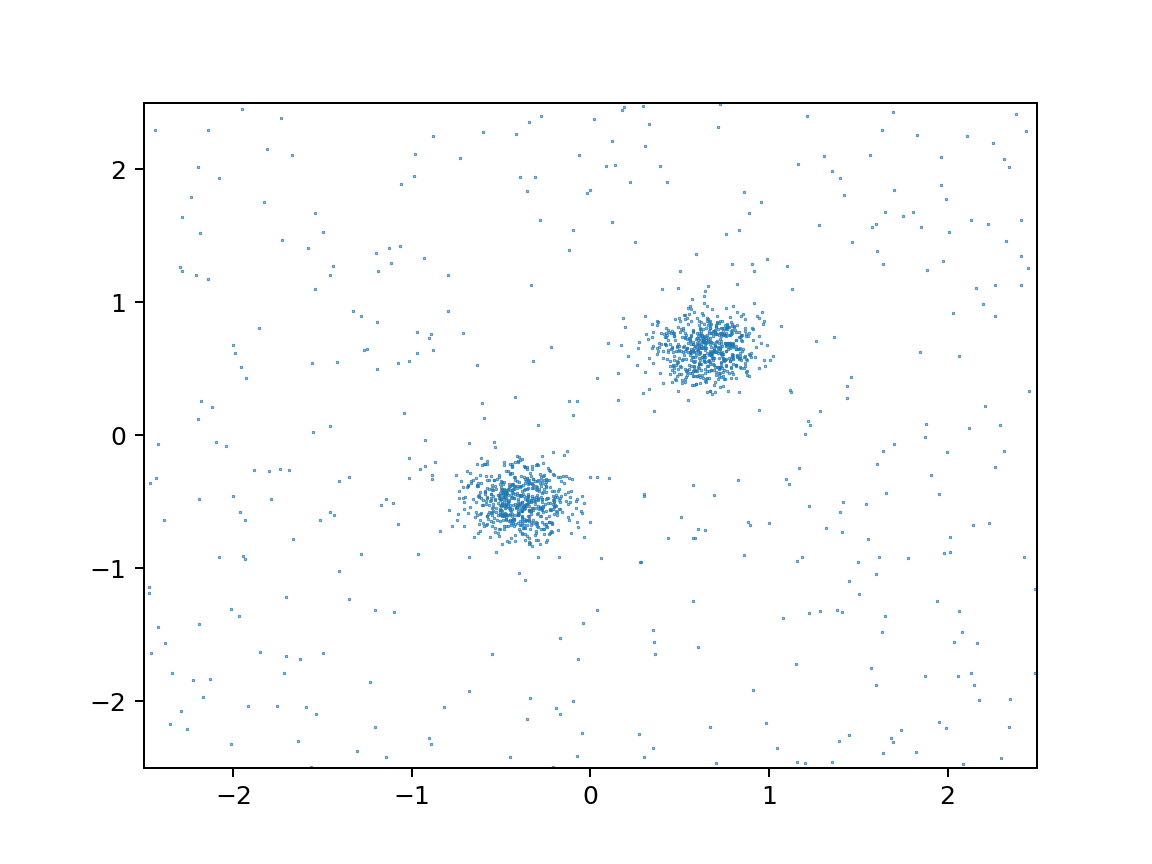

In [6]:

n = 1000
particles = np.random.random((2*200, 4)) * 5 - 2.5
particles1 = np.random.normal(0.65, 0.15, (2*300, 4))
particles2 = np.random.normal(-0.5, 0.15, (2*300, 4))
particles2[:, 0] += 0.1
particles = np.vstack((particles, particles1, particles2))

# particles = np.random.random((100, 4)) * 2 - 1

particles[:, 2:] = 0
plt.scatter(particles[:, 0], particles[:, 1], s= 0.1)
#plt.scatter(particles_list[-1][:, 0], particles_list[-1][:, 1], s=0.1)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

In [ ]:

tpoints, particles_list, trees = leapfrog(particles.copy(), t_start=0, t_end=10, N=1e3, L=5, theta=0.5,
                                         epsilon=1e-3, m_scale=1e3, multi=False)


 17%|███████████████████████████                                                                                                                                    | 170/1000 [18:49<1:37:27,  7.05s/it]

In [ ]:

tstart = time.time() 

print('[{:.2f}] Creating plot directory ...'.format(time.time() - tstart))
plot_dir = '{}/{}'.format(os.path.abspath(os.getcwd()), 'L{}n{}'.format(trees[0].length[0], n))
if not os.path.isdir(plot_dir):
    os.mkdir(os.path.join(plot_dir))

print('[{:.2f}] Initializing multiprocessing ...'.format(time.time() - tstart))
n_cpu = mp.cpu_count()
pool = mp.Pool(processes=n_cpu)

mp_trees = np.array_split(trees, n_cpu)
mp_particles = np.array_split(particles_list, n_cpu)
mp_tpoints = np.array_split(np.arange(len(tpoints)), n_cpu)
    
print('[{:.2f}] Creating plots ...'.format(time.time() - tstart))
for i in range(n_cpu):
    pool.apply_async(renderParticles, args=(mp_particles[i], mp_trees[i], mp_tpoints[i], plot_dir, 300))

pool.close()
pool.join()
print('[{:.2f}] Multiprocess concluded ...'.format(time.time() - tstart))


print('[{:.2f}] Creating video ...'.format(time.time() - tstart))

fps=30 #number of frames per second
image_files = natsorted([os.path.join(plot_dir,img) for img in os.listdir(plot_dir) if img.endswith(".png")], reverse=False)
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('test.mp4')

print('[{:.2f}] Video created ...'.format(time.time() - tstart))

_ = [os.remove(image_file) for image_file in image_files]
os.rmdir(plot_dir)
print('[{:.2f}] Directory cleaned ...'.format(time.time() - tstart))


In [ ]:
with open('./data/sim.pkl', 'wb') as f:  # open a text file
    pkl.dump({'tpoints': tpoints, 'particles_list': particles_list, 'trees': trees}, f) # serialize the list
f.close()

In [ ]:
with open('./data/sim.pkl', 'rb') as f:
    sim_dict = pkl.load(f)
    
tpoints = sim_dict['tpoints']
particles_list = sim_dict['particles_list']
trees = sim_dict['trees']

n = particles_list[0].shape[0]